In [1]:
%matplotlib widget

import torch
import torch.nn as nn
import torch.optim as optim
import simple_pinn
import matplotlib.pyplot as plt

import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

# for dev purposes, reload the simple_pinn module each time this cell is run
import importlib
importlib.reload(simple_pinn)

from mhd_utils import ideal_equation_of_state, construct_fluxes, collocation_based_PDE_residual_loss, monopole_loss, collocation_based_brio_and_wu_IC_BC_residual_loss, collocation_based_brio_and_wu_IC_BC_residual_loss_comparing_Es

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

In [2]:
# the core neural network model maps from space and time (t, x, y, z) to the *ideal* MHD state variables, which in general are
# rho, v_x, v_y, v_z, B_x, B_y, B_z, and E, where E is the total energy density;
# in this case, we are solving the 1D (in space) problem, so the model maps from (t, x) to the aforementioned state variables
mhd_state_variables_nn = simple_pinn.BrioAndWuPINN(
    2,
    [64, 64, 64, 64, 64],
    8,
    activation=nn.Tanh(),
    use_bias_in_output_layer=True,
).to(DEVICE)

optimizer = optim.Adam(mhd_state_variables_nn.parameters(), lr=0.002)

Nt = 11
Nx = 3001

t = torch.linspace(0.0, 0.02, Nt, requires_grad=True).to(DEVICE)
x = torch.linspace(-1.0, 1.0, Nx, requires_grad=True).to(DEVICE)
T, X = torch.meshgrid(t, x, indexing="ij")
inputs = torch.stack([T, X], dim=len(T.shape))

total_loss_history = []
pde_loss_history = []
mnpl_loss_history = []
ic_loss_history = []
bc_loss_history = []
n_epochs = 10_000
for epoch in range(n_epochs):
    outputs = mhd_state_variables_nn(inputs)
    F_t, F_x = construct_fluxes(outputs, ideal_equation_of_state)
    pde_loss, loss_structure = collocation_based_PDE_residual_loss(inputs, F_t, F_x)
    # mnpl_loss = monopole_loss(inputs, outputs)
    mnpl_loss = torch.tensor(0.0)
    (
        ic_loss,
        bc_loss,
        mhd_state_variables_ic_with_p,
    ) = collocation_based_brio_and_wu_IC_BC_residual_loss(
        mhd_state_variables_nn, ideal_equation_of_state, Nx=Nx, Nt=Nt, device=DEVICE
    )
    # ic_loss, bc_loss = collocation_based_brio_and_wu_IC_BC_residual_loss_comparing_Es(
    #     mhd_state_variables_nn, ideal_equation_of_state, Nx=Nx, Nt=Nt, device=DEVICE
    # )
    loss = pde_loss + ic_loss + bc_loss
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    # write out the loss values
    if epoch % 100 == 0:
        print(
            f"epoch {epoch} loss: {loss.item()} pde_loss: {pde_loss.item()} monopole_loss: {mnpl_loss.item()} ic_loss: {ic_loss.item()} bc_loss: {bc_loss.item()}"
        )
    total_loss_history.append(loss.item())
    pde_loss_history.append(pde_loss.item())
    mnpl_loss_history.append(mnpl_loss.item())
    ic_loss_history.append(ic_loss.item())
    bc_loss_history.append(bc_loss.item())

epoch 0 loss: 0.677806556224823 pde_loss: 0.0005506528541445732 monopole_loss: 0.0 ic_loss: 0.3395827114582062 bc_loss: 0.3376731872558594
epoch 100 loss: 0.02918180450797081 pde_loss: 0.0018977845320478082 monopole_loss: 0.0 ic_loss: 0.025840548798441887 bc_loss: 0.0014434714103117585
epoch 200 loss: 0.01216738112270832 pde_loss: 0.0022909294348210096 monopole_loss: 0.0 ic_loss: 0.009780311025679111 bc_loss: 9.614000009605661e-05
epoch 300 loss: 0.011531716212630272 pde_loss: 0.0030419733375310898 monopole_loss: 0.0 ic_loss: 0.008306428790092468 bc_loss: 0.00018331455066800117
epoch 400 loss: 0.012313220649957657 pde_loss: 0.004340004175901413 monopole_loss: 0.0 ic_loss: 0.007861964404582977 bc_loss: 0.00011125189485028386
epoch 500 loss: 0.010736072435975075 pde_loss: 0.003134997794404626 monopole_loss: 0.0 ic_loss: 0.007516216021031141 bc_loss: 8.485806756652892e-05
epoch 600 loss: 0.007697417866438627 pde_loss: 0.0011076412629336119 monopole_loss: 0.0 ic_loss: 0.006567336618900299 

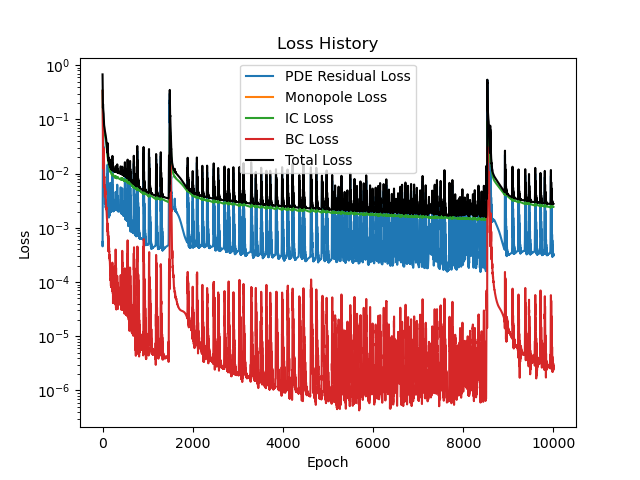

In [3]:
plt.figure()
plt.plot(pde_loss_history, label="PDE Residual Loss")
plt.plot(mnpl_loss_history, label="Monopole Loss")
plt.plot(ic_loss_history, label="IC Loss")
plt.plot(bc_loss_history, label="BC Loss")
plt.plot(total_loss_history, label="Total Loss", color="black")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss History")
plt.legend()
plt.semilogy()
plt.show()

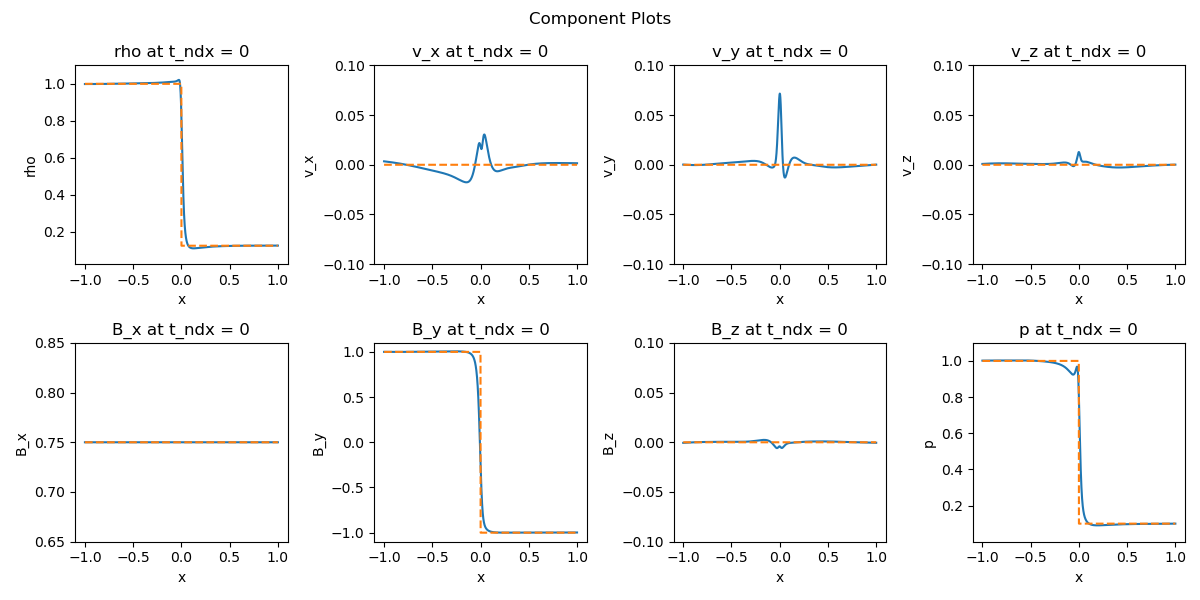

In [4]:
# t_ndx to plot
t_ndx = 0

# Get the component names
component_names = ["rho", "v_x", "v_y", "v_z", "B_x", "B_y", "B_z", "p"]

# Set up the figure and subplots
fig, axs = plt.subplots(2, 4, figsize=(12, 6))
fig.suptitle("Component Plots")

# Iterate over the components and create subplots
for i, component in enumerate(component_names):
    # Get the component values at t = t_ndx
    component_values = outputs[t_ndx, :, i].to("cpu").detach().numpy()
    component_ic_values = mhd_state_variables_ic_with_p[:, i].to("cpu").detach().numpy()

    if component == "p":
        component_values = ideal_equation_of_state(outputs[t_ndx, :].to("cpu").detach())

    # Determine the subplot position
    row = i // 4
    col = i % 4

    # Plot the component values
    axs[row, col].plot(x.to("cpu").detach().numpy(), component_values)
    axs[row, col].plot(
        x.to("cpu").detach().numpy(), component_ic_values, linestyle="--"
    )
    axs[row, col].set_xlabel("x")
    axs[row, col].set_ylabel(component)
    axs[row, col].set_title(f"{component} at t_ndx = {t_ndx}")
    y_min = component_ic_values.min() - 0.1
    y_max = component_ic_values.max() + 0.1
    axs[row, col].set_ylim([y_min, y_max])  # Set y-axis limits

# Adjust the spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()

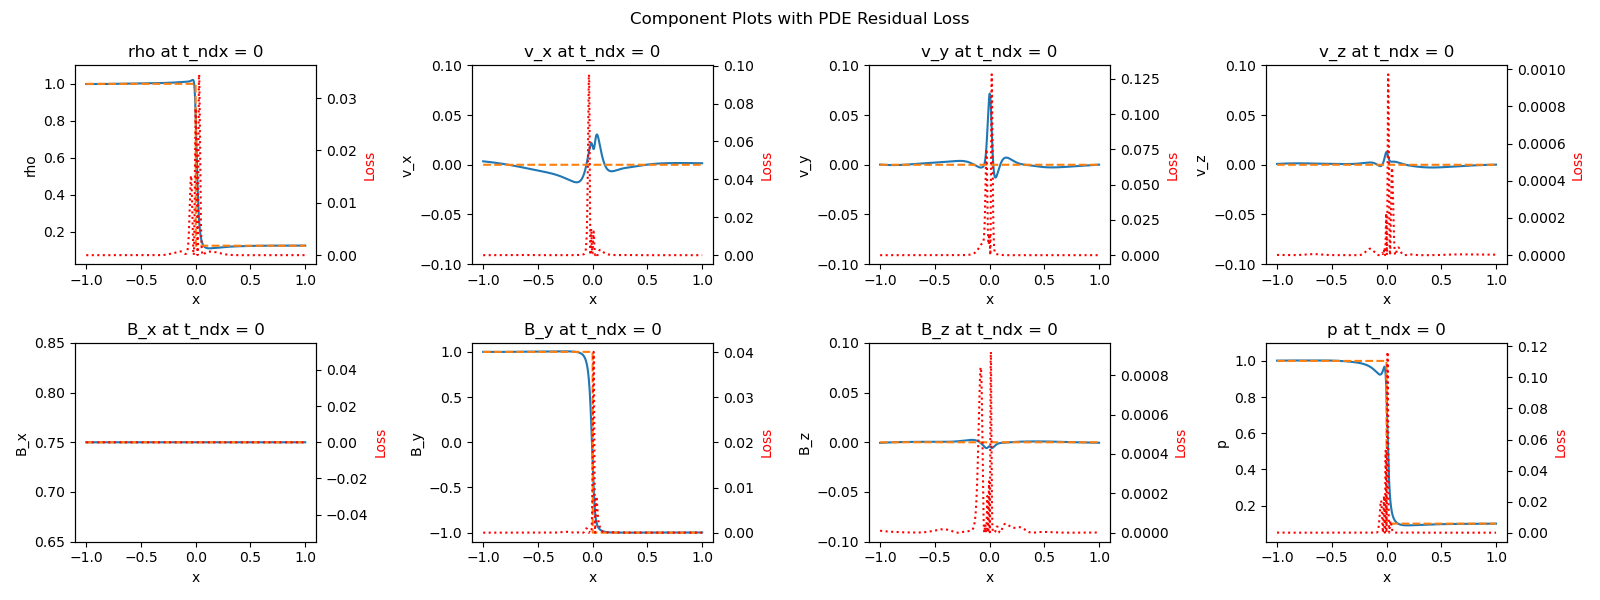

In [5]:
# t_ndx to plot
t_ndx = 0

# Get the component names
component_names = ["rho", "v_x", "v_y", "v_z", "B_x", "B_y", "B_z", "p"]

# Set up the figure and subplots
fig, axs = plt.subplots(2, 4, figsize=(16, 6))
fig.suptitle("Component Plots with PDE Residual Loss")

# Iterate over the components and create subplots
for i, component in enumerate(component_names):
    # Get the component values at t = t_ndx
    component_values = outputs[t_ndx, :, i].to("cpu").detach().numpy()
    component_ic_values = mhd_state_variables_ic_with_p[:, i].to("cpu").detach().numpy()

    if component == "p":
        component_values = ideal_equation_of_state(outputs[t_ndx, :].to("cpu").detach())

    # Determine the subplot position
    row = i // 4
    col = i % 4

    # Plot the component values
    ax = axs[row, col]
    ax.plot(x.to("cpu").detach().numpy(), component_values)
    ax.plot(x.to("cpu").detach().numpy(), component_ic_values, linestyle="--")
    ax.set_xlabel("x")
    ax.set_ylabel(component)
    ax.set_title(f"{component} at t_ndx = {t_ndx}")
    y_min = component_ic_values.min() - 0.1
    y_max = component_ic_values.max() + 0.1
    ax.set_ylim([y_min, y_max])  # Set y-axis limits

    # Create a twin axis for loss_structure
    ax2 = ax.twinx()
    ax2.plot(
        x.to("cpu").detach().numpy(),
        loss_structure[t_ndx, :, i].to("cpu").detach().numpy(),
        color="red",
        linestyle=":",
    )
    ax2.set_ylabel("Loss", color="red")

# Adjust the spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()

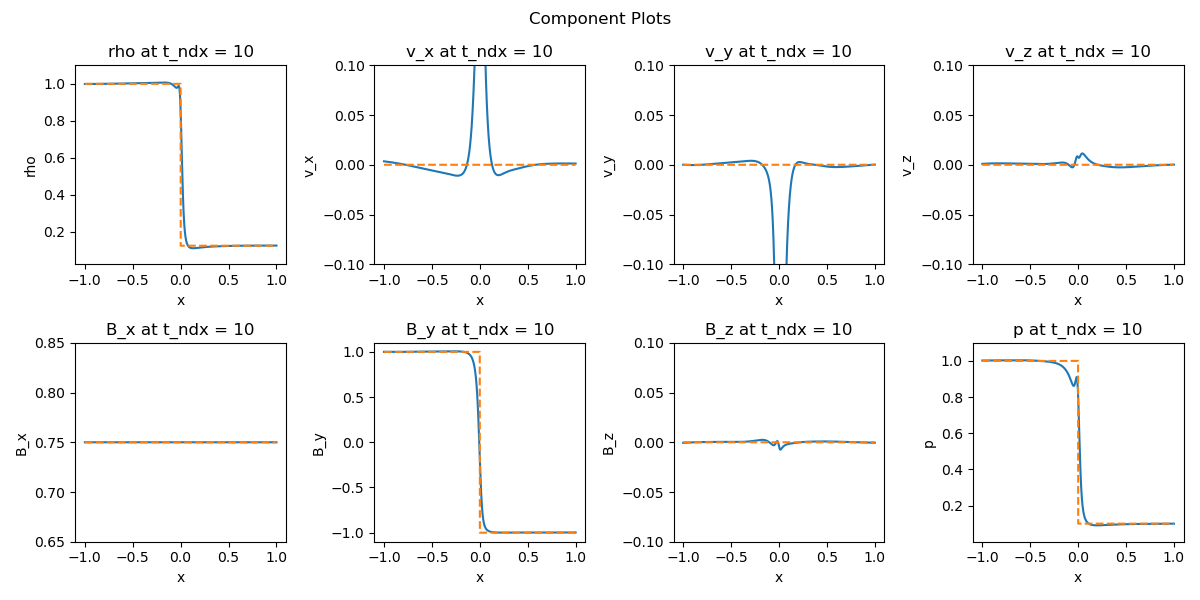

In [6]:
# Assuming 'outputs', 'mhd_state_variables_ic_with_p', and 'x' are defined, as well as 't'
t_ndx = 0

# Get the component names
component_names = ["rho", "v_x", "v_y", "v_z", "B_x", "B_y", "B_z", "p"]

# Set up the figure and subplots
fig, axs = plt.subplots(2, 4, figsize=(12, 6))
fig.suptitle("Component Plots")


def animate(t_ndx):
    # Clear previous plots
    for ax in axs.flat:
        ax.clear()

    # Iterate over the components and update subplots
    for i, component in enumerate(component_names):
        # Get the component values at the current time index
        component_values = outputs[t_ndx, :, i].to("cpu").detach().numpy()
        component_ic_values = (
            mhd_state_variables_ic_with_p[:, i].to("cpu").detach().numpy()
        )

        if component == "p":
            component_values = ideal_equation_of_state(
                outputs[t_ndx, :].to("cpu").detach()
            )

        # Determine the subplot position
        row = i // 4
        col = i % 4

        # Get the two axes for the subplot
        ax1 = axs[row, col]

        # Update the plot for the component
        ax1.plot(x.to("cpu").detach().numpy(), component_values, label="MHD Value")
        ax1.plot(
            x.to("cpu").detach().numpy(),
            component_ic_values,
            linestyle="--",
            label="Initial Condition",
        )

        ax1.set_xlabel("x")
        ax1.set_ylabel(component)
        ax1.set_title(f"{component} at t_ndx = {t_ndx}")
        y_min = component_ic_values.min() - 0.1
        y_max = component_ic_values.max() + 0.1
        ax1.set_ylim([y_min, y_max])  # Set y-axis limits for MHD values

    # Adjust the spacing between subplots
    plt.tight_layout()


# Create animation
ani = FuncAnimation(fig, animate, frames=len(t), interval=100, blit=True)

ani.save("brio_and_wu.gif", writer="pillow")

# Show the animation
# plt.show()